# \[9\]GAN 실행과 마무리정리 (필독)

전준한  
2023-12-31

# 마무리로 정리는 따로 진행하기 않겠습니다. GAN 실행으로 마무리 하겠습니다.

------------------------------------------------------------------------

### **`적대적 신경망 실행하기`**

생성자 : **`G()`** \> 판별자 : **`D()`** \> \> <br>

## \### `진행형식`

input(그림형태) <br> =\> <br> 생성자 : `D(G(input))` <br> =\> <br>
생성된 그림 : `G(input)` <br> =\> <br> 판별자 : `진짜? : D(G(input))=0`
or `가짜? : D(x)=1` —-

만들어야하는 것 : <br> `D(G(input)` 과 실제 `D(x)` 를 판별자가 더는
구별못하게 `정확도 = 0.5` 에 가까워지면 생성자의 역할이 종료

`코드` : **현재 코드는 GAN 중 페이스북의 AI 연구팀이 만든 DCGAN 입니다**

# `코드` : 그룹나누기

`[1]`

``` python
ginput= Input(shape=(100,))
dis_output= discriminator(generator(ginput))
gan = Model(ginput,dis_output)
gan.compile(loss='binary_crossentropy', optimizer='adam')
```

**`[2]`**

``` python
def gan_train(epoch, batch_size, saving_interval):
    (X_train, _), (_, _) = mnist.load_data()  # 들여쓰기 및 괄호 오류 수정
    X_train = X_train.reshape(X_train.shape[0], 28, 28, 1).astype('float32')
    X_train = (X_train - 127.5) / 127.5
    true = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))

    for i in range(epoch):
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        imgs = X_train[idx]
        d_loss_real = discriminator.train_on_batch(imgs, true)

        noise = np.random.normal(0, 1, (batch_size, 100))
        gen_imgs = generator.predict(noise)
        d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)

        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)  # d_loss 계산 수정
        g_loss = gan.train_on_batch(noise, true)

        print('epoch:%d' % i, 'd_loss:%.4f' % d_loss, 'g_loss:%.4f' % g_loss)

        if i % saving_interval == 0:
            noise = np.random.normal(0, 1, (25, 100))
            gen_imgs = generator.predict(noise)
            gen_imgs = 0.5 * gen_imgs + 0.5

            fig, axs = plt.subplots(5, 5)
            count = 0
            for j in range(5):
                for k in range(5):
                    axs[j, k].imshow(gen_imgs[count, :, :, 0], cmap='gray')
                    axs[j, k].axis('off')
                    count += 1
            fig.savefig("gan_images/gan_mnist_%d.png" % i)  # 들여쓰기 및 변수명 수정

gan_train(4001, 32, 200)  # 함수 호출 위치 수정
```

### - `[GAN 해석]`

`[1]`

``` python
ginput= Input(shape=(100,))
dis_output= discriminator(generator(ginput))
gan = Model(ginput,dis_output)
gan.compile(loss='binary_crossentropy', optimizer='adam')
```

-   이 코드는 생성자와 판별자 모델을 연결시키는 gan 모델입니다.
-   input : keras.layers 의 함수로 인풋의 크기를 `shape`로 받습니다.
-   dis_output : D(G(input)) 을 수행하고 있습니다. - input 에 generator
    모델을 쭉 돌리고 discriminator 모델을 쭉 돌린 것입니다.
-   gan : Model(ginput,dis_output) 은 keras.models 의 함수로 Model(a,b)
    로 a 에는 input

`[2]`

``` python
def gan_train(epoch, batch_size, saving_interval):
```

\### `-` 신경망을 실행시키는 함수로 그 내부는 이렇게 작용합니다.

`MNIST 데이터 불러오기` <br> `MNIST 의 이미지 활용`<br>
`실제 데이터 판별자에 입력`<br> `가상 이미지를 판별자에 입력`<br>
`판별자와 생성자의 오차 계산`<br> `gan_images 저장시키기.`<br>
`4000번마다 (batch_size=32) 200번마다 결과 저장`<br>

`-` GAN full model writing

1.  import
2.  생성자모델 만드기
3.  판별자모델만들기
4.  생성자와 판별자 모델 연결시키는 gan 모델 만들기
5.  신경망실행함수 만들기
6.  신경망실행함수 실행하여 결과보기

In [4]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input,Dense, Reshape,Flatten,Dropout
from tensorflow.keras.layers import BatchNormalization,Activation, LeakyReLU, UpSampling2D,Conv2D
from tensorflow.keras.models import Sequential, Model
import numpy as np
import matplotlib.pyplot as plt

In [5]:
generator = Sequential()
generator.add(Dense(128*7*7 , input_dim=100 , activation=LeakyReLU(0.2)))
generator.add(BatchNormalization())
generator.add(Reshape((7,7,128)))
generator.add(UpSampling2D()) # ...(1)
generator.add(Conv2D(64,kernel_size=5,padding='same'))
generator.add(BatchNormalization())
generator.add(Activation(LeakyReLU(0.2)))
generator.add(UpSampling2D()) # ...(2)
generator.add(Conv2D(1, kernel_size=5,padding='same',activation='tanh'))

In [6]:
discriminator = Sequential()
discriminator.add(Conv2D(64,kernel_size=5,strides=2,input_shape=(28,28,1),padding='same'))
discriminator.add(Activation(LeakyReLU(0.2)))
discriminator.add(Dropout(0.3))
discriminator.add(Conv2D(128,kernel_size=5,strides=2,padding='same'))
discriminator.add(Activation(LeakyReLU(0.2)))
discriminator.add(Dropout(0.3))
discriminator.add(Flatten())
discriminator.add(Dense(1,activation='sigmoid'))
discriminator.compile(loss='binary_crossentropy',optimizer='adam')
discriminator.trainable=False

In [7]:
ginput= Input(shape=(100,)) #ginput 은 `g`an 의 `input` 을 의미
dis_output= discriminator(generator(ginput))
gan = Model(ginput,dis_output)
gan.compile(loss='binary_crossentropy', optimizer='adam')
gan.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100)]             0         
                                                                 
 sequential (Sequential)     (None, 28, 28, 1)         865281    
                                                                 
 sequential_1 (Sequential)   (None, 1)                 212865    
                                                                 
Total params: 1078146 (4.11 MB)
Trainable params: 852609 (3.25 MB)
Non-trainable params: 225537 (881.00 KB)
_________________________________________________________________

In [ ]:
# 지금하고있는 폴더에 이미지 저장을 위해 gan_images 라는 폴더를 만들어놓으세요. 

1/1 [==============================] - 0s 33ms/step
epoch:0 d_loss:0.4201 g_loss:0.0707
1/1 [==============================] - 0s 34ms/step
epoch:1 d_loss:0.6238 g_loss:0.0202
1/1 [==============================] - 0s 32ms/step
epoch:2 d_loss:0.7434 g_loss:0.0363
1/1 [==============================] - 0s 33ms/step
epoch:3 d_loss:0.5985 g_loss:0.2081
1/1 [==============================] - 0s 31ms/step
epoch:4 d_loss:0.4993 g_loss:0.6196
1/1 [==============================] - 0s 31ms/step
epoch:5 d_loss:0.5383 g_loss:0.7894
1/1 [==============================] - 0s 32ms/step
epoch:6 d_loss:0.5563 g_loss:0.7735
1/1 [==============================] - 0s 32ms/step
epoch:7 d_loss:0.4962 g_loss:0.6669
1/1 [==============================] - 0s 32ms/step
epoch:8 d_loss:0.4591 g_loss:0.6281
1/1 [==============================] - 0s 31ms/step
epoch:9 d_loss:0.3943 g_loss:0.7066
1/1 [==============================] - 0s 31ms/step
epoch:10 d_loss:0.3382 g_loss:0.9139
1/1 [==========================

/tmp/ipykernel_129241/911656145.py:27: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axs = plt.subplots(5, 5)

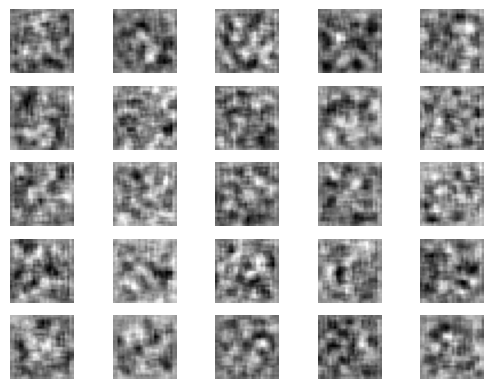

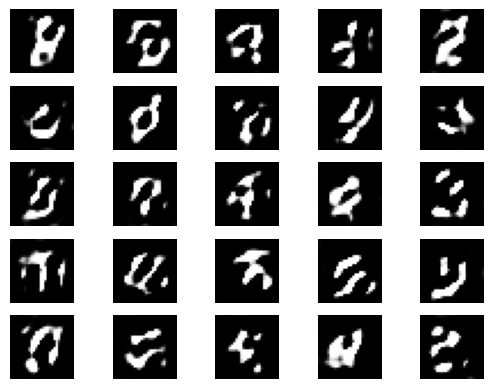

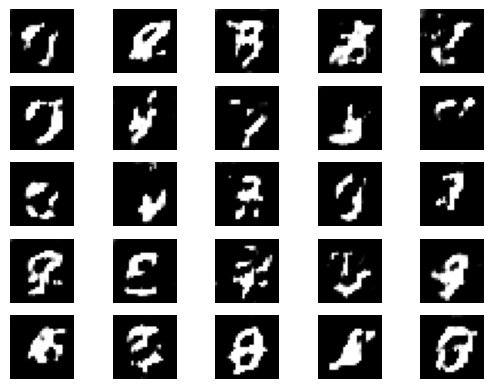

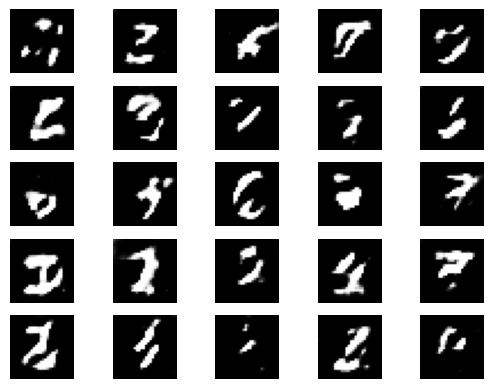

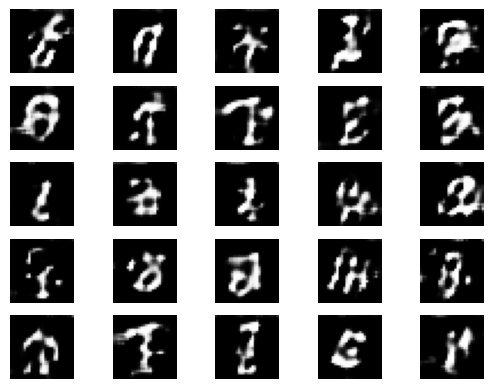

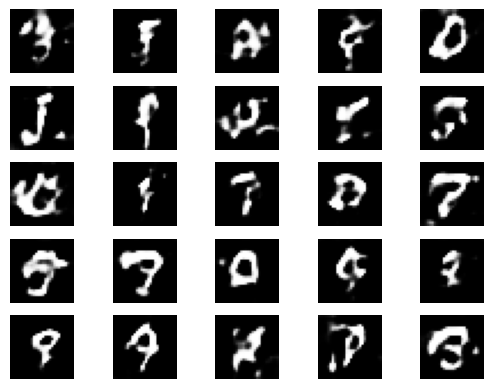

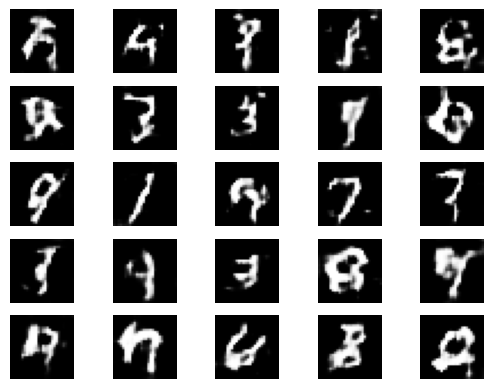

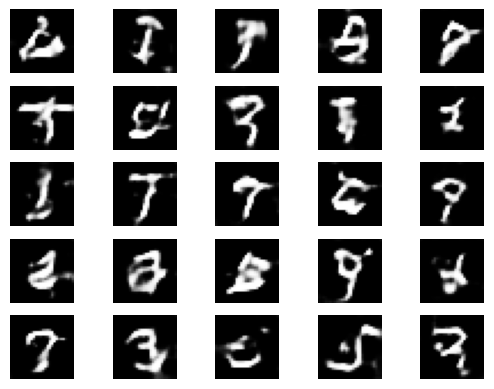

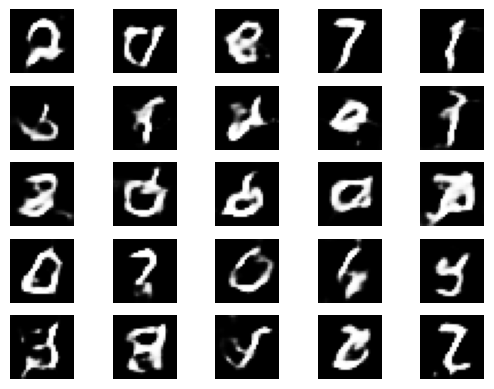

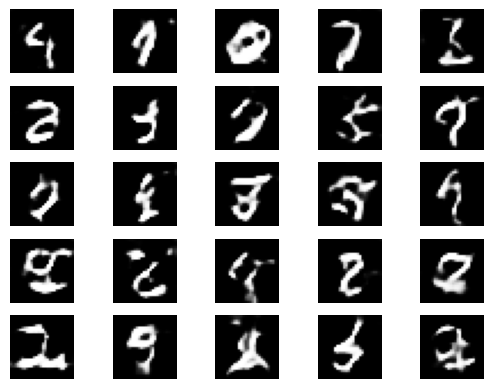

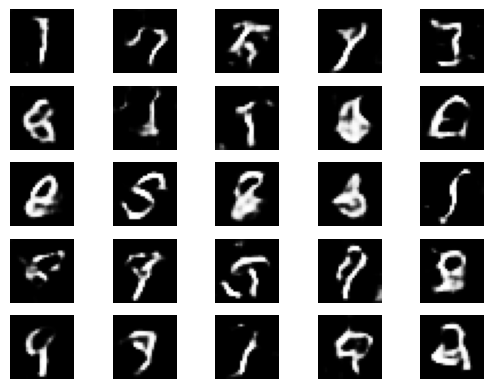

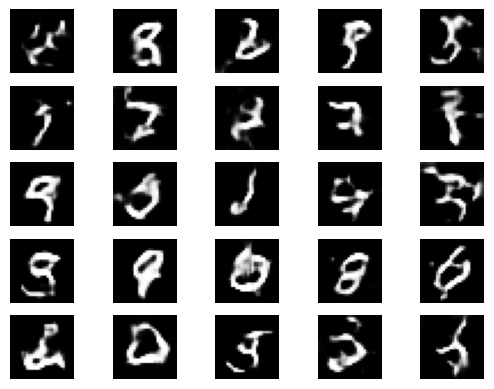

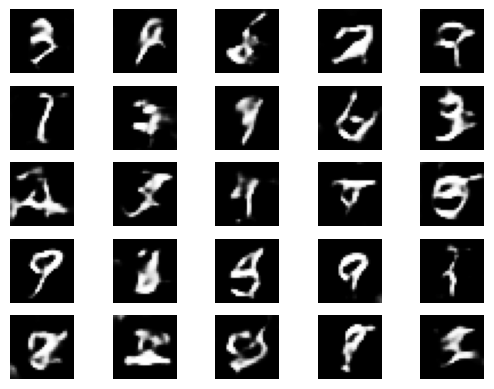

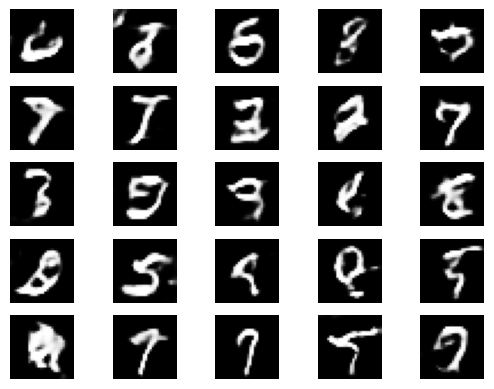

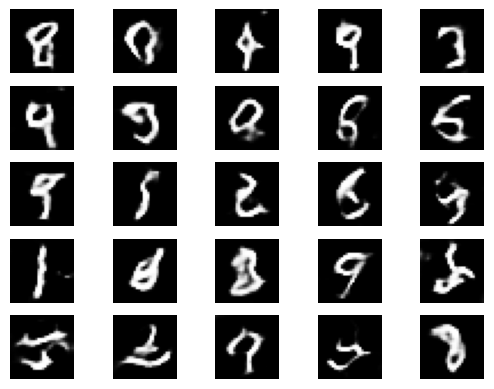

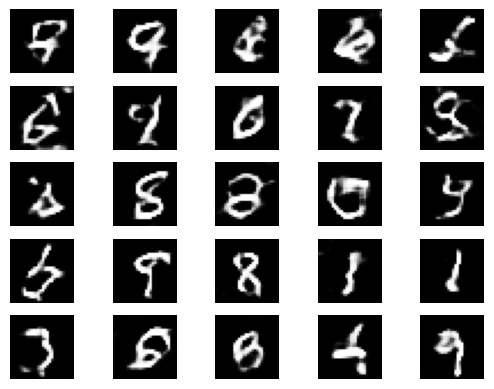

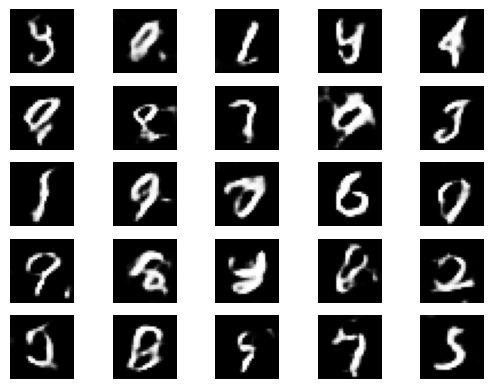

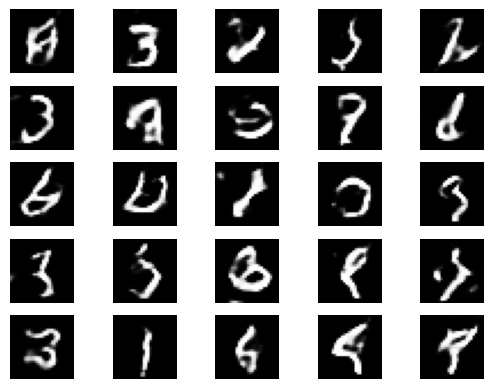

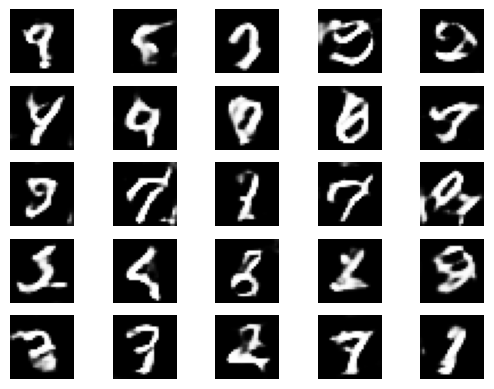

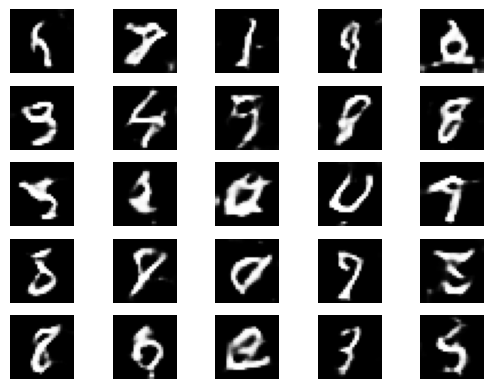

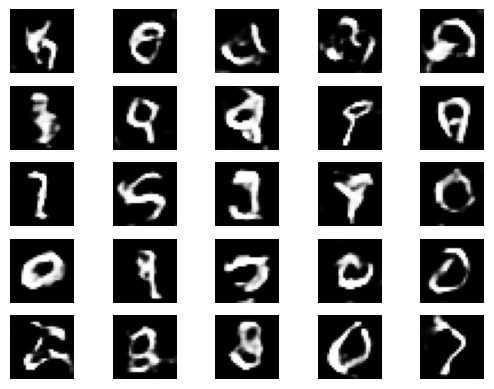

In [18]:
def gan_train(epoch, batch_size, saving_interval):
    (X_train, _), (_, _) = mnist.load_data()  # X_train 만 필요하고 나머지는 임의의 변수로 필요없다는 의미입니다.
    X_train = X_train.reshape(X_train.shape[0], 28, 28, 1).astype('float32')
    X_train = (X_train - 127.5) / 127.5 #60000,28,28,1 의 사진들에서 255의 절반인 127.5 를 빼주면서 -1과1사이로 정규화
    true = np.ones((batch_size, 1)) #32,1
    fake = np.zeros((batch_size, 1)) #32,1

    for i in range(epoch):
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        imgs = X_train[idx]
        d_loss_real = discriminator.train_on_batch(imgs, true)

        noise = np.random.normal(0, 1, (batch_size, 100))
        gen_imgs = generator.predict(noise)
        d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)

        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)  # d_loss 계산 수정
        g_loss = gan.train_on_batch(noise, true)

        print('epoch:%d' % i, 'd_loss:%.4f' % d_loss, 'g_loss:%.4f' % g_loss)

        if i % saving_interval == 0:
            noise = np.random.normal(0, 1, (25, 100))
            gen_imgs = generator.predict(noise)
            gen_imgs = 0.5 * gen_imgs + 0.5

            fig, axs = plt.subplots(5, 5)
            count = 0
            for j in range(5):
                for k in range(5):
                    axs[j, k].imshow(gen_imgs[count, :, :, 0], cmap='gray')
                    axs[j, k].axis('off')
                    count += 1
            fig.savefig("gan_images/gan_mnist_%d.png" % i)  # 들여쓰기 및 변수명 수정

gan_train(4001, 32, 200)  # 함수 호출 위치 수정

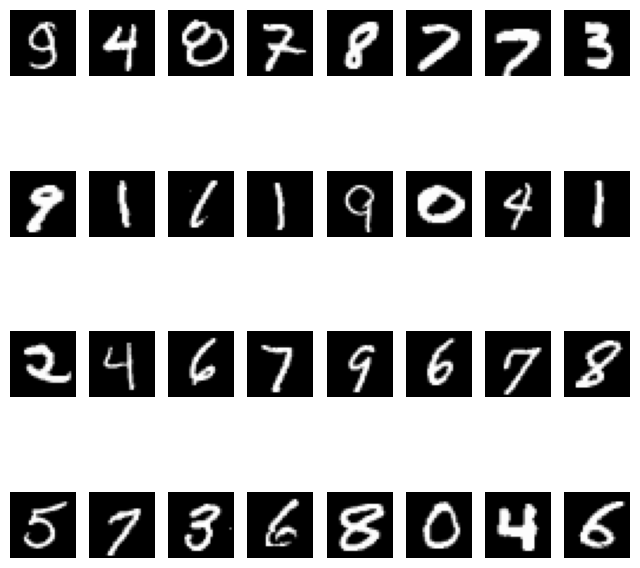

In [23]:
import matplotlib.pyplot as plt
import numpy as np

# X_train 데이터에서 무작위로 32개 이미지를 선택합니다.
random_indices = np.random.randint(0, X_train.shape[0], 32)

# 선택한 이미지를 그립니다.
plt.figure(figsize=(8, 8))
for i, idx in enumerate(random_indices):
    plt.subplot(4, 8, i + 1)
    plt.imshow(X_train[idx].reshape(28, 28), cmap='gray')
    plt.axis('off')

plt.show()


결과적으로

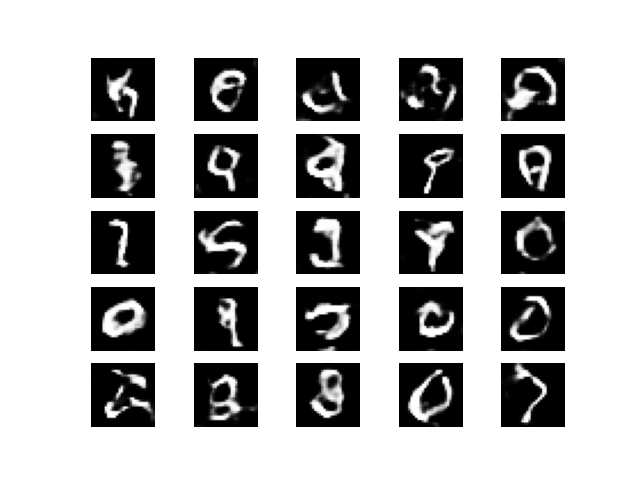

In [45]:
from IPython.display import Image, display
display(Image(filename='gan_images/gan_mnist_4000.png'))

### 구분할 수 없는 이미지 만들었다는데 아직 보완이 필요해 보입니다.

-   사람이 보았을 때 누가봐도 컴퓨터가 만든거잖아!